# Task 10.2. Segmentation by division and merging
---
***Author: Piotr Skalski***

## 1. Imports

In [10]:
import numpy as np
import cv2
import os
import pprint
from tqdm import tqdm

import display_util

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Primary settings

In [11]:
SOURCE_DIR = "./../data/"
IMAGE_NAME = "umbrealla.png"

## 3. Loading images

In [12]:
# building path to file
image_path = os.path.join(SOURCE_DIR, IMAGE_NAME)
# loading files
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image = image[:, :, 0]

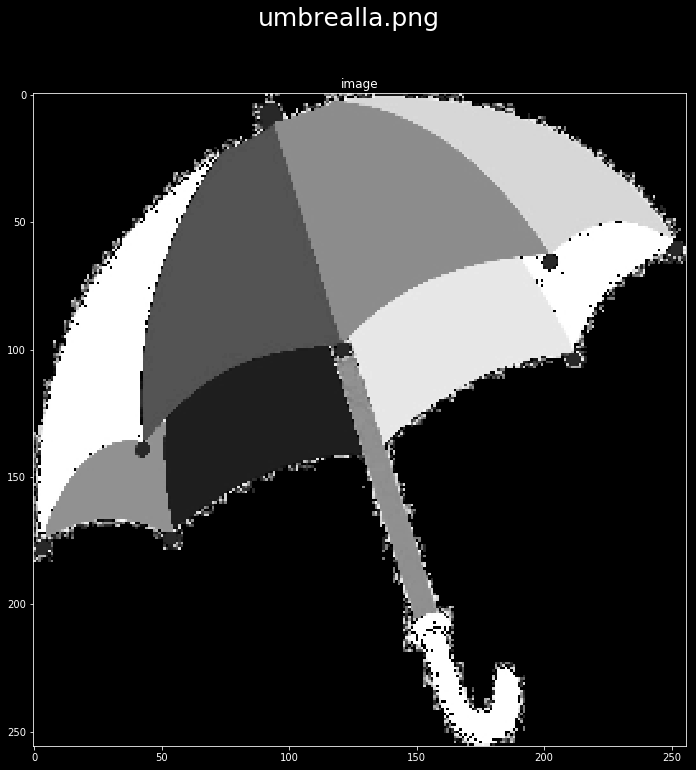

In [13]:
display_util.image(image, IMAGE_NAME, size=(12,12))

## 4. Segmentation by division and merging method

### 4.1. Settings

In [14]:
MIN_SEGMENT_SHAPE = (8, 8)
STD_DEV_DIVISION_THRESHOLD = 0.5
HUE_MERGE_THRESHOLD = 5.0

### 4.2. Implementation

In [15]:
def quadruple(segment, segment_anchor):
    segment_shape = segment.shape
    y_marker = segment_shape[0] // 2
    x_marker = segment_shape[1] // 2
    return [
        (segment[:y_marker, :x_marker], segment_anchor),
        (segment[:y_marker, x_marker:], (segment_anchor[0], segment_anchor[1] + x_marker)),
        (segment[y_marker:, :x_marker], (segment_anchor[0] + y_marker, segment_anchor[1])),
        (segment[y_marker:, x_marker:], (segment_anchor[0] + y_marker, segment_anchor[1] + x_marker))
    ]

In [21]:
def split(segment, segment_anchor, index, seg_res, m_res, segment_index_cache, min_segment_shape = (8, 8), std_dev_devision_threshold = 1.0):
    segment_shape = segment.shape
    segment_std_dev = segment.std()
    
    if (segment_shape[0] >= min_segment_shape[0] and segment_shape[1] >= min_segment_shape[1] and segment_std_dev > std_dev_devision_threshold):
        segment_quarters = quadruple(segment, segment_anchor)
        for sub_segment, sub_segment_anchor in segment_quarters:
            seg_res, m_res, segment_index_cache, index = split(sub_segment, sub_segment_anchor, index, seg_res, m_res, segment_index_cache, min_segment_shape, std_dev_devision_threshold)
        return seg_res, m_res, segment_index_cache, index
    else:
        seg_res[
            segment_anchor[0]:segment_anchor[0] + segment_shape[0], 
            segment_anchor[1]:segment_anchor[1] + segment_shape[1]
        ] = index
        m_res[
            segment_anchor[0]:segment_anchor[0] + segment_shape[0], 
            segment_anchor[1]:segment_anchor[1] + segment_shape[1]
        ] = segment.mean()
        segment_index_cache[index] = (segment_anchor, segment_shape)
        index += 1
        return seg_res, m_res, segment_index_cache, index

In [22]:
def segmentation(image, min_segment_shape = (8, 8), std_dev_devision_threshold = 1.0, hue_merge_threshold = 5):
    image_shape = image.shape
    seg_res = np.zeros(image_shape)
    m_res = np.zeros(image_shape)
    segment_index_cache = {}
    index = 1
    
    # DIVISION PHASE
    seg_res, m_res, segment_index_cache, index = split(image, (0, 0), index, seg_res, m_res, segment_index_cache, min_segment_shape, std_dev_devision_threshold)
    
    return seg_res, m_res, segment_index_cache

In [24]:
index_matrix, mean_matrix, segment_index_cache = segmentation(image, MIN_SEGMENT_SHAPE, STD_DEV_DIVISION_THRESHOLD, HUE_MERGE_THRESHOLD)

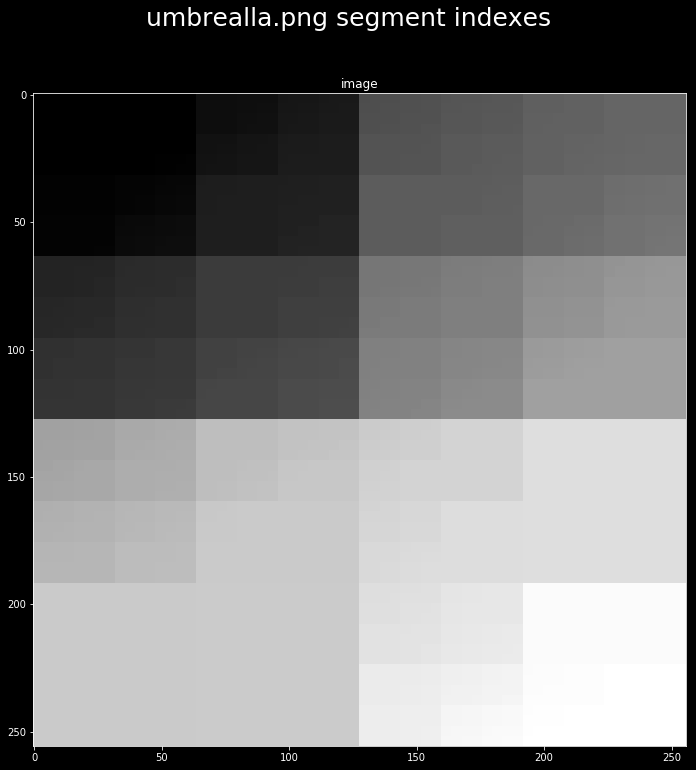

In [25]:
display_util.image(index_matrix, IMAGE_NAME + " segment indexes", size=(12,12))

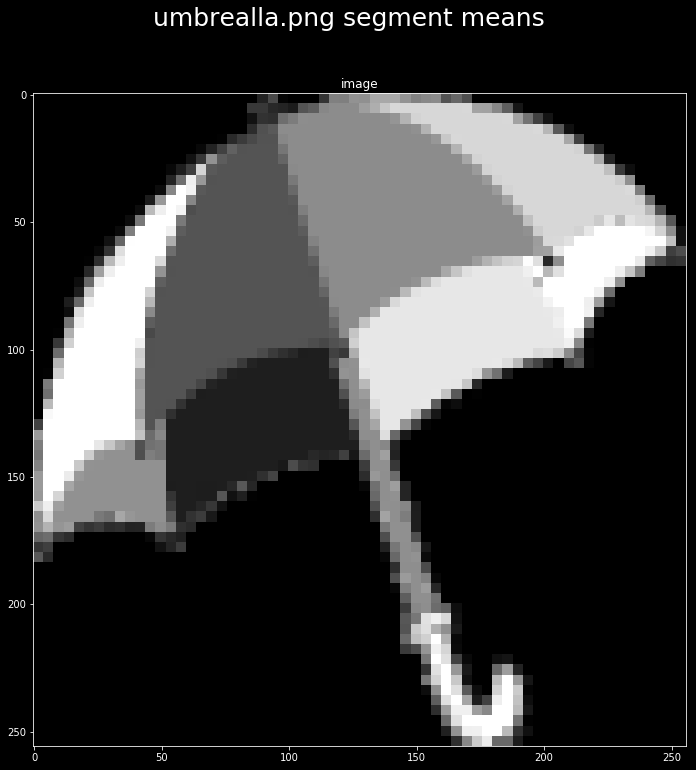

In [26]:
display_util.image(mean_matrix, IMAGE_NAME + " segment means", size=(12,12))

In [27]:
segment_index_cache

{1: ((0, 0), (32, 32)),
 2: ((0, 32), (16, 16)),
 3: ((0, 48), (16, 16)),
 4: ((16, 32), (16, 16)),
 5: ((16, 48), (8, 8)),
 6: ((16, 56), (8, 8)),
 7: ((24, 48), (4, 4)),
 8: ((24, 52), (4, 4)),
 9: ((28, 48), (4, 4)),
 10: ((28, 52), (4, 4)),
 11: ((24, 56), (4, 4)),
 12: ((24, 60), (4, 4)),
 13: ((28, 56), (4, 4)),
 14: ((28, 60), (4, 4)),
 15: ((32, 0), (16, 16)),
 16: ((32, 16), (16, 16)),
 17: ((48, 0), (16, 16)),
 18: ((48, 16), (8, 8)),
 19: ((48, 24), (8, 8)),
 20: ((56, 16), (8, 8)),
 21: ((56, 24), (4, 4)),
 22: ((56, 28), (4, 4)),
 23: ((60, 24), (4, 4)),
 24: ((60, 28), (4, 4)),
 25: ((32, 32), (8, 8)),
 26: ((32, 40), (8, 8)),
 27: ((40, 32), (8, 8)),
 28: ((40, 40), (4, 4)),
 29: ((40, 44), (4, 4)),
 30: ((44, 40), (4, 4)),
 31: ((44, 44), (4, 4)),
 32: ((32, 48), (4, 4)),
 33: ((32, 52), (4, 4)),
 34: ((36, 48), (4, 4)),
 35: ((36, 52), (4, 4)),
 36: ((32, 56), (4, 4)),
 37: ((32, 60), (4, 4)),
 38: ((36, 56), (4, 4)),
 39: ((36, 60), (4, 4)),
 40: ((40, 48), (4, 4)),
 